# Quality Analysis of Iron Ore Refining via Flotation
This project analyzes a large dataset from an iron mining operation. A critical step in this operation is flotation refining, where ore is purified/silica is removed. Flotation uses physical properties in combination with a few reagents to separate silica from the high-quality ore. 

### Why is Predicting Quality Important?
Prior to the refined ore being shipped to a smelter, it must undergo lab testing to ensure its quality. For both economic and chemical property reasons, the ore must be over a certain purity. Unfortunately, lab testing happens only after the refining process is complete. If the refined ore is too high in silica, it must be thrown away with tailings (waste product of mining) or recycled with fresh ore. The latter option, however, is expensive and time consuming. With a predictive model, engineers can adjust feed rates of ore, chemicals, and agitators without lab intervention increasing efficiency and decreasing waste.

### Dataset
The dataset contains 723,000 records across 24 variables. 

https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

**Dataset Columns Overview:**
- Date
- % Iron Feed
- % Silica Feed
- Starch Flow
- Amina Flow (reagent)
- Ore Pulp Flow, pH, and Density
- Flotation Column 1-7: Air Flow and Level
- Output Variables: % Iron Concentrate and % Silica Concentrate


## Step 1: Import Libraries and Load Data
In this section the important libraries will be loaded for later and the data will be loaded into a dataframe.
This is the foundation for the exploratory analysis and later regression model. 

In [2]:
#import libraries for later use
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#load data from local source
#change directory to where the file is located on your machine
%cd /Users/mkcer/OneDrive - Marquette University/4.1 Super Senior (24-25)/ECON 6118 Python Code/directjupfolder/Final Project
    
#list files to ensure it is there
%ls
    
#load csv into dataframe using pandas read_csv, using decimal = ','
    #this was creating errors where some percentages were in the billions, had to designate decimal seperator 
df = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv', parse_dates = ['date'], index_col = 'date', decimal = ',')

#check to ensure csv read correctly
print(df.head())

C:\Users\mkcer\OneDrive - Marquette University\4.1 Super Senior (24-25)\ECON 6118 Python Code\directjupfolder\Final Project
 Volume in drive C is OS
 Volume Serial Number is CE2D-57B1

 Directory of C:\Users\mkcer\OneDrive - Marquette University\4.1 Super Senior (24-25)\ECON 6118 Python Code\directjupfolder\Final Project

04/16/2025  12:35 PM    <DIR>          .
04/15/2025  10:45 AM    <DIR>          ..
04/15/2025  10:44 AM    <DIR>          .ipynb_checkpoints
04/16/2025  12:35 PM           207,569 ECON6118_Final_Project_Matthew_Ceranski.ipynb
04/15/2025  10:45 AM       183,766,261 MiningProcess_Flotation_Plant_Database.csv
               2 File(s)    183,973,830 bytes
               3 Dir(s)  249,439,309,824 bytes free
                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
date                                                                       
2017-03-10 01:00:00         55.2          16.98      3019.53     557.434   
2017-03-10 01:00:00         55.2          

## Step 2: Data Manipulation and Exploratory Data Analysis
Prior to deeper analysis, the data must be cleaned and manipulated. This data requires a lot of cleaning, as stated by the provider of the data. I will be focusing on two main issues. 
1) The data was collected in a method that induces some errors with csv files. For example, some % silica concentrations are in the billions, when they can only be 0-100%. This was fixed by using (decimal=',') in pd.read_csv. Using .describe() on the cleaned dataframe showed that there were no further problematic columns. 
2) The data was collected in mismatched time intervals without proper labeling. The good news is that the lab results were collected in hourly increments and assigned to the other measurements without regard for time stamping. The scale of this process is on that of multiple hours, so averaging hourly readings should still provide valuable results. After extensive cleaning and hourly averaging, this dataset will contain over 4,100 records. 

Null values and duplicate lines will be removed.

Later in the analysis, I want to explore what factors affect the increase in ore quality most. To make this quicker, a column
will be created to show the change in ore quality called delta_iron. 

Finally, .describe() will be used to perform a basic analysis on the dataframe.


In [4]:
#check for nulls, remove
df.dropna(inplace=True)

#check for duplicates, remove
df.drop_duplicates(inplace=True)

#create column for percent change in ore quality
df['delta_iron'] = df['% Iron Concentrate'] - df['% Iron Feed']

#average data by hourly timestamp to line up with lab collected values
df_hourly = df.groupby('date').mean()

#basic stats using describe
print(df_hourly.describe())
print('------------')

#view top three lines of the newly created dataframe
df_hourly.head(3)

       % Iron Feed  % Silica Feed  Starch Flow   Amina Flow  Ore Pulp Flow  \
count  4097.000000    4097.000000  4097.000000  4097.000000    4097.000000   
mean     56.294730      14.651733  2868.915033   488.160636     397.577005   
std       5.158347       6.808236   950.895934    83.694790       8.370186   
min      42.740000       1.310000    54.595483   242.927477     376.837604   
25%      52.670000       8.940000  2168.968993   436.037967     398.848778   
50%      56.080000      13.850000  2908.578878   502.454283     399.841806   
75%      59.720000      19.600000  3528.727412   549.522256     400.584861   
max      65.780000      33.400000  6270.158798   736.982378     418.070232   

       Ore Pulp pH  Ore Pulp Density  Flotation Column 01 Air Flow  \
count  4097.000000       4097.000000                   4097.000000   
mean      9.767704          1.680399                    280.151387   
std       0.378065          0.063759                     29.409908   
min       8.75338

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,delta_iron
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.2,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,250.178287,...,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31,11.71
2017-03-10 02:00:00,55.2,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,250.033317,...,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11,11.86
2017-03-10 03:00:00,55.2,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,250.046350,...,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27,11.77


## Step 3: Statistical Exploratory Data Analysis
To understand what variables might most influence the model, a statistical analysis is performed on two hypotheses. 

### Hypothesis 1:
**Does the mean of % Increase of Iron Concentration (delta_ore) differ based on high vs. low Amina flow rates?**

I suspect that the flow of amina (a critical reagent) has a lot to do with the refining process. Because there are no trials where amina is omitted the statistical analysis will be grouped between trials where amina flow was above average and trials where it was below average.

To do this I created a column with the help of numpy.where(). This function returns an element based on a condition, which I set to be the average flow rate of amina.

In [6]:
#testing hypothesis 1
#create column which classifies amina flow as high or low based on average amina flow
df_hourly['AFR'] = np.where(df_hourly['Amina Flow'] > df_hourly['Amina Flow'].mean(), 'High', 'Low')

#use groupby to evaluate
#difference in max delta_iron
max_di = df_hourly.groupby('AFR').max()

#difference in average delta_iron
avg_di = df_hourly.groupby('AFR').mean()

#range of each group to compare results
min_di = df_hourly.groupby('AFR').min()

#display results
print("Difference in Iron Enrichment at High and Low Amine Flow Rates")
print('---------------------------')
print('Max change in iron concentration of final product')
print(max_di['delta_iron'])
print('---------------------------')
print('Average change in iron concentration of final product')
print(avg_di['delta_iron'])
print('---------------------------')
print('Range of change in iron concentration of final product')
print(max_di['delta_iron'] - min_di['delta_iron'])

Difference in Iron Enrichment at High and Low Amine Flow Rates
---------------------------
Max change in iron concentration of final product
AFR
High    23.2
Low     23.3
Name: delta_iron, dtype: float64
---------------------------
Average change in iron concentration of final product
AFR
High    8.920479
Low     8.544218
Name: delta_iron, dtype: float64
---------------------------
Range of change in iron concentration of final product
AFR
High    25.070000
Low     25.113682
Name: delta_iron, dtype: float64


### What did we learn
The average change in iron concentration was slightly higher for the group with a higher than average amina flow. However, this difference is small especially considering the range. More significant statistical testing, such as a t-test, should be done to confirm significance. 

### Hypothesis 2:
**Is there a significant correlation between Ore Pulp Density and % Iron Concentrate?**

I was curious to see if ore pulp that started out heavier would indicate a higher iron concentration (and therefore rely less on the process parameters). If this is the case, one could argue that the mining operation should carefully create their ore pulp to reduce the potential for waste.

To do this I will be performing a Pearson correlation test using scipy.stats. The test will be examining the ore pulp density (input) and its correlation to the resulting iron concentration in the final product (output). 

BONUS: I felt the correlation test was really quick, so I decided to perform a t test on the amina flow rate from Hypothesis 1. 

In [8]:
#testing hypothesis 2
#perform perason correlation test
pearson_test = stats.pearsonr(df_hourly['Ore Pulp Density'], df_hourly['% Iron Concentrate'])

#because this was very easy, i wanted to test the hypothesis from above and see if it was a significant result
#create groups for ttest
high_amina = df_hourly[df_hourly['AFR'] == 'High']['delta_iron']
low_amina = df_hourly[df_hourly['AFR'] == 'Low']['delta_iron']

#perform ttest
ttest = stats.ttest_ind(high_amina, low_amina, equal_var = False)

#print results from the test
print('Pearson Correlation Test Results')
print('---------------------------')
print(pearson_test)
print('Amina Flow Rate Difference Test Results')
print('---------------------------')
print(ttest)

Pearson Correlation Test Results
---------------------------
PearsonRResult(statistic=0.016675032577955134, pvalue=0.28593533060004417)
Amina Flow Rate Difference Test Results
---------------------------
TtestResult(statistic=2.2877259666992007, pvalue=0.022207707371992833, df=3832.86902866372)


### What did we learn
Pearson Correlation test: the test statistic shows that the correlation is nearly zero. Additionally the p value indicates that the result is not statistically significant, and any correlation is likely due to random variation. 

T Test: The p value is less than 0.05 which indicates that there IS a statistically significant difference between high and low amina flow rates. This was very interesting to see and highlights the importance of performing in depth statistical tests as opposed to 'going with your gut'. 

## Step 4: Visual Exploratory Data Analysis

Another method that can provide valuable information is exploratory plots. These plots may show relationships or trends over time. 

### Plot 1:
**Relationship between Starch Flow and Change in Iron Ore Quality (delta_ore)**

This exploratory plot aims to describe the relationship between the other main reagent (starch) and the final ore quality. I did a statistical analysis on amina, so I found it fitting to do a visual analysis on starch. If there is a significant increase in the quality of the iron with a higher flow of starch, there should be a distinct line forming on the plot. 

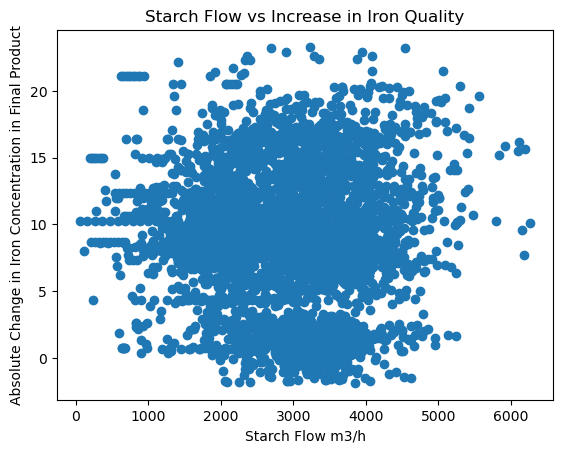

In [10]:
#creating plot 1
#create plot showing starch flow vs increase in iron quality
plt.scatter(df_hourly['Starch Flow'], df_hourly['delta_iron'])

#add title
plt.title('Starch Flow vs Increase in Iron Quality')

#add x and y lables
plt.xlabel('Starch Flow m3/h')
plt.ylabel('Absolute Change in Iron Concentration in Final Product')

#show plot
plt.show()

### What did we learn

This exploratory plot shows that there is no significant trend in relation between just starch flow and an increase in the quality of the final iron ore product. 

### Plot 2:
**Correlation Matrix: Iron Quality Correlation to % Iron Feed, Ore Pulp Flow, Average Air Agetation, and Amina Flow**

Until this point, I have not discovered many correlations between a single variable and the outcome of the final iron ore quality. This was a bit discouraging, but I needed to remember that one expert on the matter claimed that this was a 'perfect example' of an engineering system. Many input variables interacted with each other, which made it hard to isolate a single point of success. To explore more of these variables at once and how they interact with each other I decided to make a correlation matrix of the remaining variables. To keep it readable, I averaged the total air flow values across all 7 tanks. 

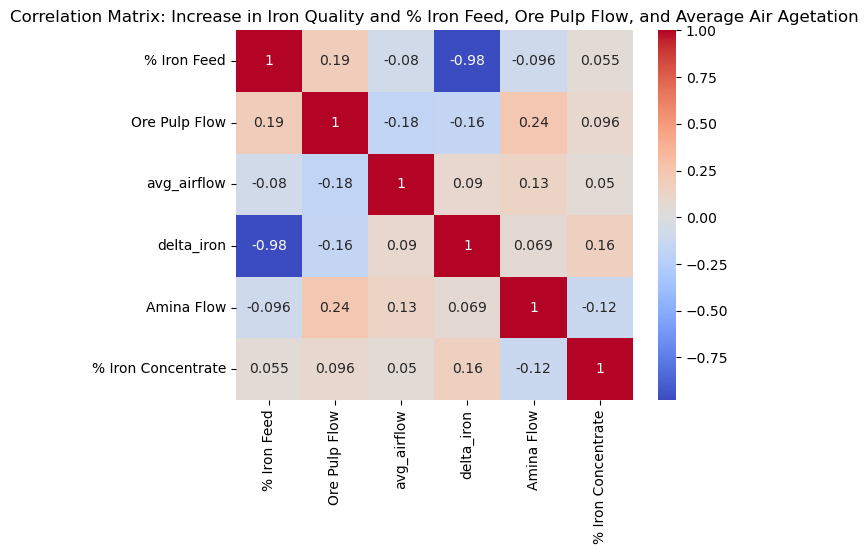

In [12]:
#create plot 2
#create an averaged air flow column
df_hourly['avg_airflow'] = df_hourly[[
    'Flotation Column 01 Air Flow',
    'Flotation Column 02 Air Flow',
    'Flotation Column 03 Air Flow',
    'Flotation Column 04 Air Flow',
    'Flotation Column 05 Air Flow',
    'Flotation Column 06 Air Flow',
    'Flotation Column 07 Air Flow']].mean(axis = 1)

#create the correlation matrix
correlation_matrix = df_hourly[['% Iron Feed', 'Ore Pulp Flow', 'avg_airflow', \
                                'delta_iron', 'Amina Flow', '% Iron Concentrate']].corr()
#plot using seaborn
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix: Increase in Iron Quality and % Iron Feed, Ore Pulp Flow, and Average Air Agetation')
plt.show()

### What did we learn

This exploratory plot showed some interesting correlations. First, I noticed that there was a strong negative correlation between % Iron Feed and delta_iron. This shows that as the quality of the product entering refining goes up, the total quality change between the feed ore and the final product goes down. This makes sense for two reasons. 1) The process likely has an upper limit to how much it can purify iron ore and 2) The mining operation is likely aiming for a set target (ideal values for iron flotation are a final product quality of 67-68%). Next I noticed a slight correlation between Amina Flow and Ore Pulp Flow. This is intuitive: as more ore flows through the system, more amina must be fed into the system to keep reaction ratios the same. The rest of the correlation matrix did not show much, but this is still a very powerful tool for exploratory data analysis! 

## Step 5: Supervised Learning - Predicting % Iron Concentrate (and % Silica Concentrate)

Finally, I aimed to create a regression model that can predict the final concentration of iron in the final product given the refining parameters. I chose to do a RandomForest model for two reasons. First, from my analysis above, I understood that there were certainly a lot of interactions between the variables that were not apparent with basic analysis. This style of regression model should help fully realize the complex interactions between variables. Second, I wanted to expand my skillset. I have never created a RandomForest model, so this was a great exercise. 
**Note: In order to reduce noise in my model, I utilized the average hourly airflow across all tanks. Additionally, I created a variable that tracked the average hourly level of the tanks.**

I worked on this model for quite a while and found that my results were average at best. On Kaggle, there were many comments discussing how their models were extremely accurate, and they had no problems cleaning the data and implementing this model. It took me a long time to realize why my model was not matching up with their model (and, in my opinion, why their model was not usable). Most users were attempting to predict '% Silica Concentrate', which was another lab measured value. They didn't, however, drop the column '% Iron Concentrate' when training or testing their models! In essence, they were using a lab measured value (% Iron Concentrate) which was highly correlated to the other lab measured value (% Silica Concentrate). Most of the accuracy from these models came from a lab measured attribute, so the model would be unusable to guide the process in real time! 

I then set out to remedy this situation. I felt that I could get more useful information out of this dataset. I wanted to compare two linear models: one that predicted the final iron concentration of the product and one that predicted the change in quality between the feed ore and the final product. I felt like the latter would provide insight into the process parameters. With a model that predicts the increase in quality, we may understand more about the flotation process.


In [14]:
#randomforest regressor model
#create flotation column level average to reduce noise
df_hourly['avg_level'] = df_hourly[[
    'Flotation Column 01 Level',
    'Flotation Column 02 Level',
    'Flotation Column 03 Level',
    'Flotation Column 04 Level',
    'Flotation Column 05 Level',
    'Flotation Column 06 Level',
    'Flotation Column 07 Level']].mean(axis = 1)

#designate input and output variables
x = df_hourly[['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 
'Ore Pulp pH', 'Ore Pulp Density', 'avg_airflow', 'avg_level']]
y = df_hourly['% Iron Concentrate']

#split training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 20)

#fit model
rand = RandomForestRegressor(n_estimators = 50, random_state = 50)
rand.fit(x_train,y_train)

#test model against test data
rand_pred=rand.predict(x_test)

#evaluate model
#mean square of error
print('MSE Absolute Concentration Prediction:', mean_squared_error(y_test, rand_pred))
#mean average error
print('MAE Absolute Concentration Prediction:', mean_absolute_error(y_test, rand_pred))
#r^2 value
print('R2 Absolute Concentration Prediction:', rand.score(x_test, y_test))

MSE Absolute Concentration Prediction: 0.9239856877435085
MAE Absolute Concentration Prediction: 0.7381583526503321
R2 Absolute Concentration Prediction: 0.27995237096170067


### What did we learn
The Random Forest model explained approximately 28% of the variance in iron concentrate outcomes. This suggests that it captures some key relationships but many process inter-variable relationships may be needed to improve predictive performance.

In [17]:
#linear model focusing on increase in quality rather than overall quality
#designate input and output variables
x = df_hourly[['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 
'Ore Pulp pH', 'Ore Pulp Density', 'avg_airflow', 'avg_level']]
y_conc = df_hourly['% Iron Concentrate']
y_delta = df_hourly['delta_iron']

#split training and testing data
x_train_conc, x_test_conc, y_train_conc, y_test_conc = train_test_split(x, y_conc, test_size = 0.25, random_state = 20)
x_train_delta, x_test_delta, y_train_delta, y_test_delta = train_test_split(x, y_delta, test_size = 0.25, random_state = 20)

#fit concentration model
lin_conc = LinearRegression()
lin_conc.fit(x_train_conc, y_train_conc)

#fit delta model
lin_delta = LinearRegression()
lin_delta.fit(x_train_delta, y_train_delta)

#test concentration model against test data
lin_pred_conc = lin_conc.predict(x_test_conc)

#test delta model against test data
lin_pred_delta = lin_delta.predict(x_test_delta)

#evaluate model
#mean square of error aboslute concentration
print('MSE Absolute Concentration Prediction:', mean_squared_error(y_test_conc, lin_pred_conc))
#mean average error absolute concentration
print('MAE Absolute Concentration Prediction:', mean_absolute_error(y_test_conc, lin_pred_conc))
#r^2 value absolute concentration
print('R2 Absolute Concentration Prediction:', lin_conc.score(x_test_conc, y_test_conc))
print('---------------------------------------')
#mean square of error change in iron quality
print('MSE Delta Concentration Prediction:', mean_squared_error(y_test_delta, lin_pred_delta))
#mean average error change in iron quality
print('MAE Delta Concentration Prediction:', mean_absolute_error(y_test_delta, lin_pred_delta))
#r^2 value change in iron quality
print('R2 Delta Concentration Prediction:', lin_delta.score(x_test_delta, y_test_delta))

MSE Absolute Concentration Prediction: 1.1722344017149005
MAE Absolute Concentration Prediction: 0.8707036823331786
R2 Absolute Concentration Prediction: 0.08649602171516613
---------------------------------------
MSE Delta Concentration Prediction: 1.1722344017148962
MAE Delta Concentration Prediction: 0.8707036823331772
R2 Delta Concentration Prediction: 0.9544989654081188


### What did we learn
The linear model was highly effective at predicting the change in iron concentration (delta_iron). However, it performed poorly when predicting the final concentration value, with an R² of just 0.09. This suggests the model is better at capturing relative changes in quality rather than absolute outcomes.

### Outcome and Further Exploration
I learned a lot from this analysis, but I think the greatest takeaway is that there is a significant relationship between these variables that was unexplored through this analysis. If I were to continue working with this dataset, I would want to evaluate these interactions through an ANOVA table and select some of the most important interactions. I only have experience doing this through Minitab, but at some point, I would like to learn how to do this through Python (because its free and I can use it anywhere!). This kind of advanced statistical analysis would take me much too long to learn for this project, but this project has sparked my interest.
